In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt

seedno = 123456
rng = np.random.default_rng(seed=seedno)

## Model parameters


In [2]:
sigma = 1.
S0 = 100.
T = 1.
lambda_a = 10.
lambda_b = 10.
qmax = 3
qmin = -qmax
sigma_Z = 1.
kappa = 100.
# Model for misses
alpha_a = 1/kappa - 0.001
alpha_b = 1/kappa - 0.001
beta = 0.001

# Penalties
phi = 1e-4
a = 1e-5

In [3]:
all_inventories = np.arange(qmax, qmin-1, step = -1)

## Implementation

In [4]:
A_matrix = np.zeros((2*qmax+1,2*qmax+1))
z_vector = np.zeros((2*qmax+1,1))

for i in range(2*qmax+1):
    inventory = qmax - i
    A_matrix[i, i] = - phi * kappa * inventory**2
    z_vector[i, 0] = np.exp(- a * kappa * inventory**2)
    if i + 1 < (2*qmax+1):
        A_matrix[i, i + 1] = lambda_b * np.exp(-1.+kappa*alpha_b + kappa*beta/2)
    if i > 0:
        A_matrix[i, i - 1] = lambda_a * np.exp(-1.+kappa*alpha_a + kappa*beta/2)


In [5]:
def _calculate_omega_t(t):
    return np.matmul(expm(A_matrix * (T - t)) - beta*(lambda_a-lambda_b)**2*(T**2-t**2)/2*np.identity(2*qmax+1) , z_vector)

In [6]:
def _calculate_gt(t):
    omega_function = _calculate_omega_t(t)
    return 1 / kappa * np.log(omega_function)

def _calculate_ft(t):
    return beta*(lambda_a - lambda_b)*t

In [7]:
gt = _calculate_gt(0.5)

In [8]:
def _calculate_deltas(t, q, d_plus_z, take_maximum = False):    
    delta_tilde_a = alpha_a + beta * (d_plus_z)
    delta_tilde_b = alpha_a - beta * (d_plus_z)
    g_qs  = _calculate_gt(t)
    
    ft = _calculate_ft(t)
    dz_minus_one = ft*(d_plus_z-1) - beta/2*(d_plus_z-1)**2
    dz_same = ft*(d_plus_z) - beta/2*(d_plus_z)**2
    dz_plus_one = ft*(d_plus_z+1) - beta/2*(d_plus_z+1)**2
    indices = np.clip(qmax - q, 0, 2 * qmax)
    indices = indices.astype(int)
    indices_minus_one = np.clip(indices - 1, 0, 2 * qmax)
    indices_plus_one = np.clip(indices + 1, 0, 2 * qmax)
    
    h_q_minus_one = np.squeeze(g_qs[indices_minus_one]) + dz_same
    h_d_minus_one = np.squeeze(g_qs[indices])+ dz_minus_one
    
    h_q_plus_one = np.squeeze(g_qs[indices_plus_one]) + dz_same
    h_d_plus_one = np.squeeze(g_qs[indices])+ dz_plus_one
    
    delta_hat_a = 1/kappa - h_q_minus_one + h_d_minus_one
    delta_hat_b = 1/kappa - h_q_plus_one + h_d_plus_one
    
    if take_maximum:
        delta_a = np.maximum(delta_hat_a, delta_tilde_a)
        delta_b = np.maximum(delta_hat_b, delta_tilde_b)
        return delta_a, delta_b
    else:
        return delta_hat_a, delta_hat_b

# Numerics

In [10]:
t = 0.5
d_plus_z = 0

q_vector = np.arange(qmax-1,qmin,step=-1)

deltas_a = np.zeros((q_vector.shape))
deltas_b = np.zeros((q_vector.shape))

for i,q in enumerate(q_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
    deltas_a[i] = delta_a
    deltas_b[i] = delta_b

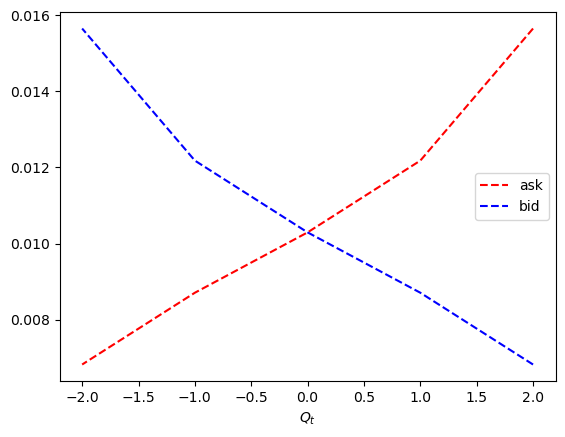

In [11]:
plt.plot(q_vector, deltas_a, 'r--')
plt.plot(q_vector, deltas_b, 'b--')
plt.xlabel(r'$Q_t$')
plt.legend(['ask','bid'])
plt.show()

In [13]:
t = 0.5
q = 0
dmax = 5
dmin = - dmax

d_plus_z_vector = np.arange(dmax-1,dmin,step=-1)

deltas_a = np.zeros((d_plus_z_vector.shape))
deltas_b = np.zeros((d_plus_z_vector.shape))

for i,d_z in enumerate(d_plus_z_vector):
    delta_a, delta_b = _calculate_deltas(t, q, d_z)
    deltas_a[i] = delta_a
    deltas_b[i] = delta_b

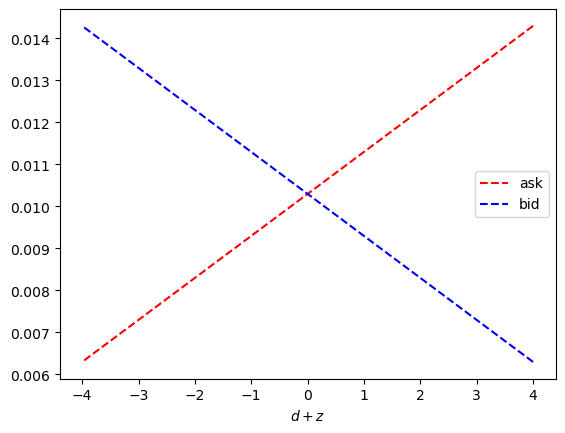

In [14]:
plt.plot(d_plus_z_vector, deltas_a, 'r--')
plt.plot(d_plus_z_vector, deltas_b, 'b--')
plt.xlabel(r'$d+z$')
plt.legend(['ask','bid'])
plt.show()

In [15]:
t_vector = np.linspace(0,T,num=100)
q_vector = np.arange(qmax-1,qmin,step=-1)

d_plus_z = 0


deltas_a = np.zeros((t_vector.shape[0],q_vector.shape[0]))
deltas_b = np.zeros((t_vector.shape[0],q_vector.shape[0]))

for it,t in enumerate(t_vector):
    for iq,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, d_plus_z)
        deltas_a[it,iq] = delta_a
        deltas_b[it,iq] = delta_b

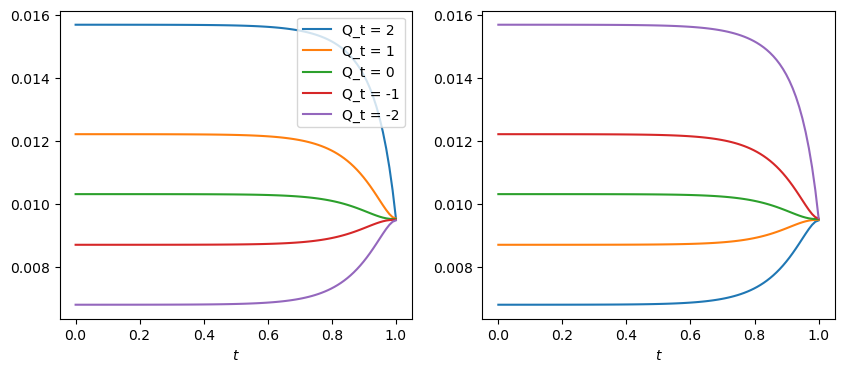

In [16]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
for iq,q in enumerate(q_vector):
    ax[0].plot(t_vector, deltas_a[:,iq])
    ax[1].plot(t_vector, deltas_b[:,iq])
ax[0].legend([f'Q_t = {q}' for q in q_vector])
ax[0].set_xlabel(r'$t$')
ax[1].set_xlabel(r'$t$')
plt.show()

# Experiments!

#### One simulation -- we will think about vectorising this later on

In [17]:
def brownian(Nt=1000, S0=0, sigma=0.01):
    timesteps = np.linspace(0, T, Nt)
    path = np.zeros(Nt)
    path[0] = S0
    Z = rng.normal(0,1, Nt)
    for n in range(1, Nt):
        path[n] = path[n-1] + sigma * np.sqrt(T/Nt) * Z[n]
    return path

def get_arrival(sims, dt, lambda_a, lambda_b):
    unif_a = rng.uniform(size=(sims,))
    unif_b = rng.uniform(size=(sims,))
    return unif_a < 1. - np.exp(-lambda_a * dt), unif_b < 1. - np.exp(-lambda_b * dt)

In [18]:
Nt = 1000
sims = 10
dt = T/Nt

X = np.zeros((sims,Nt+1))
Q = np.zeros((sims,Nt+1))
D = np.zeros((sims,Nt+1))
S = np.zeros((sims,Nt+1))
Z = np.zeros((sims,Nt+1))

S[:,0] = S0

time = np.linspace(0, T, Nt+1)

In [19]:
for it,t in enumerate(time[:-1]):   
    delta_a, delta_b = _calculate_deltas(t, Q[:,it], D[:,it]+Z[:,it])
    
    aux_normal = rng.normal(0, 1)
    Z[:,it+1] = Z[:,it] + sigma_Z *  np.sqrt(T/Nt) * aux_normal
    aux_normal = rng.normal(0, 1)
    S[:,it+1] = S[:,it] + sigma *  np.sqrt(T/Nt) * aux_normal
    
    arrival_a, arrival_b = get_arrival(sims, dt, lambda_a, lambda_b)
    
    fill_a = rng.uniform(size=(sims,))
    fill_b = rng.uniform(size=(sims,))
    
    delta_tilde_a = alpha_a + beta * (D[:,it] + Z[:,it])
    delta_tilde_b = alpha_b - beta * (D[:,it] + Z[:,it])
    
    prob_a = np.minimum(np.exp(-kappa*(delta_a - delta_tilde_a)),1)
    prob_b = np.minimum(np.exp(-kappa*(delta_b - delta_tilde_b)),1)
    
    filled_trade_a = fill_a < prob_a
    filled_trade_b = fill_b < prob_b
    
    #print(delta_a.shape)
    #print(delta_tilde_a.shape)
    #print(filled_trade_b.shape)
    #print(arrival_b.shape)
    Q[:,it+1] = Q[:,it] - filled_trade_a*arrival_a + filled_trade_b*arrival_b
    D[:,it+1] = D[:,it] - (1-filled_trade_a)*arrival_a + (1-filled_trade_b)*arrival_b
    
    X[:,it+1] = X[:,it] + filled_trade_a*arrival_a*(S[:,it] + delta_a) - filled_trade_b*arrival_b*(S[:,it] - delta_a)
    

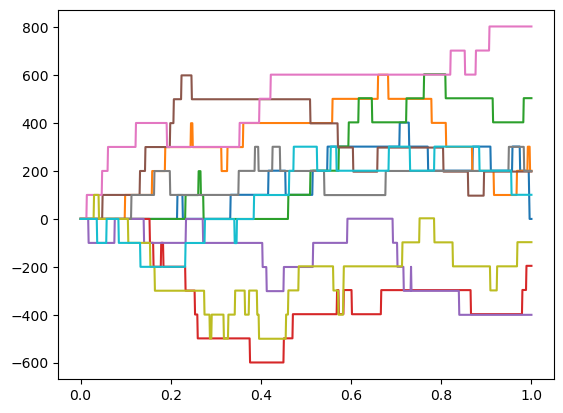

In [20]:
plt.plot(time, np.transpose(X))
plt.show()